## Data Modeling

In [5]:
#Imported Libraries
import pickle 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, RandomForestClassifier

### Data Preparation

The code below will first separate the X (predictor) and y (target) variables. Features isolated from the Logistic Regression are used as predictors together with the engineered website_link column. The y-variable will be stratified to maintain the 54% positive and 46% negative ratio. Lastly, a  function called metric will print out the testing and training accuracy, specificity, and sensitivity scores. 

In [6]:
#Read cleaned and tokenized data
train = pd.read_csv('../data/train_clean_token.csv', index_col=0)

#Load saved feature_list and add website_link column to the features
feature = pickle.load(open('pickle/feature.pkl', "rb"))
feature.append('website_link')

#Identify the X and y variable and split the data into training and testing set 
X = train[feature]
y = train['label']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, stratify=y)

#A metric function that prints out training and testing accuracy, specificity, and sensitivity score. 
def metric(model): 
    '''Print out testing and training accuracy, sensitivity, and specificity score'''
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print(f'Best Paramters: {model.best_params_}')
    print(f'Training score: {model.score(X_train, y_train)}')
    print(f'Testing score: {model.score(X_test, y_test)}')
    print(f'Specificity: {tn/(tn + fp)}')
    print(f'Sensitivity: {tp/(tp + fn)}')

### Modeling 
Since the model's goal is to classify tweets as a positive or negative class accurately, a Random Forest Classifier and Gradient Boosting Classifier were chosen since they are excellent at getting high accuracy scores. However, they also tend to overfit quickly. Therefore, Logistic Regression and Multinomial Naive Bayes are used in conjunction with the two mentioned models. This is because they are simpler and easier models to regularize. To further maximize the accuracy score, a Voting Classifier was created comprising the three out of the four models mentioned with the highest testing accuracy score (Logistic Regression, Gradient Boosting Classifier, and Random Forest Classifier). Lastly, sensitivity and specificity are considered as metrics to measure model success. 

In [9]:
#Setup Voting Classifier that will be use to aggregate models with high accuracy score.
vote = VotingClassifier([
    ('gb', GradientBoostingClassifier(random_state=42, min_samples_leaf=5, 
                                             min_samples_split=4)),
    ('rf', RandomForestClassifier(random_state=42, min_samples_leaf=5, min_samples_split=2)),
    ('lr', LogisticRegression(solver='liblinear'))
])

#List of models
model = [LogisticRegression(solver='liblinear'), MultinomialNB(), 
         GradientBoostingClassifier(random_state=42),
        RandomForestClassifier(random_state=42),
        vote]

#List of names to be use to label model
model_short = ['lr', 'nb', 'gb', 'rf', 'vote']

#List of names to be use to separate models
model_name = ['Logictics Regression', 'Multinomial Naive Bayes', 
              'Gradient Boosting Classifier', 'Random Forest Classifier', 'Voting Classifier'] 

#Model parameters 
alpha = np.logspace(-2,10,15) 
lr_param = {'C': alpha}
nb_param = {'alpha': alpha}
gb_param = {'learning_rate': [0.2], 'n_estimators': [100],'max_features' : [None, 'auto'], 
            'min_samples_split':[5]}
rf_param =  {'min_samples_split': [2,3,4],'min_samples_leaf': [5], 'max_features' : [None, 'auto']}
vote_param = {'lr__C': alpha}

params = [lr_param, nb_param, gb_param, rf_param, vote_param]
              
#A list to store trained models 
trained_models = [] 

#For Loop that will fit and run a Gridsearch to fine-tune each model. 
#It would then print out metric scores using the metric function defined above. 
for i in range(len(model_name)):
    print(f'Model {i+1}: {model_name[i]}')
    param = params[i]
    model_short[i] = GridSearchCV(model[i], param, cv=5)
    model_short[i].fit(X_train, y_train)
    metric(model_short[i])
    trained_models.append(model_short[i])
    print("")

Model 1: Logictics Regression
Best Paramters: {'C': 3.727593720314938}
Training score: 0.8276699029126213
Testing score: 0.8115942028985508
Specificity: 0.7777777777777778
Sensitivity: 0.84

Model 2: Multinomial Naive Bayes
Best Paramters: {'alpha': 0.01}
Training score: 0.7766990291262136
Testing score: 0.7753623188405797
Specificity: 0.7301587301587301
Sensitivity: 0.8133333333333334

Model 3: Gradient Boosting Classifier
Best Paramters: {'learning_rate': 0.2, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 100}
Training score: 0.9344660194174758
Testing score: 0.8478260869565217
Specificity: 0.8095238095238095
Sensitivity: 0.88

Model 4: Random Forest Classifier
Best Paramters: {'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2}
Training score: 0.8131067961165048
Testing score: 0.7898550724637681
Specificity: 0.7619047619047619
Sensitivity: 0.8133333333333334

Model 5: Voting Classifier
Best Paramters: {'lr__C': 26.826957952797247}
Training score: 0

### Confusion Matrix: 
A confusion matrix was used to assess the specificity and sensitivity scores. Out of the five models, the Voting Classifier performs best with the highest testing accuracy score without overfitting, while minimizing the false positives and negatives.

1. Logistic Regression
2. Multinomial Naive Bayes 
3. Gradient Boosting Classifier 
4. Random Forest Classifier
5. Voting Classifier  

Logistic Regression


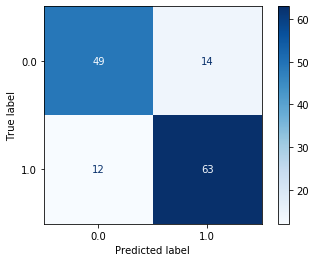

In [160]:
print('Logistic Regression')
plot_confusion_matrix(trained_models[0], X_test, y_test, cmap='Blues');

MultinomialNB


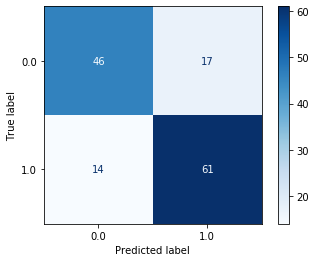

In [163]:
print('MultinomialNB')
plot_confusion_matrix(trained_models[1], X_test, y_test, cmap='Blues');

Gradient Boosting Classifier


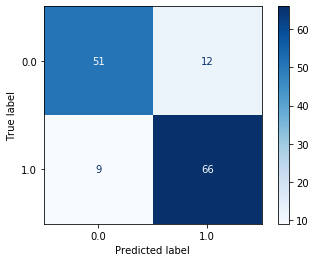

In [164]:
print('Gradient Boosting Classifier')
plot_confusion_matrix(trained_models[2], X_test, y_test, cmap='Blues');

Random Forest Classifier


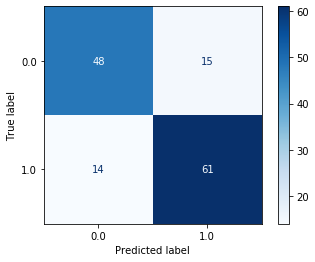

In [165]:
print('Random Forest Classifier')
plot_confusion_matrix(trained_models[3], X_test, y_test, cmap='Blues');

Voting Classifier


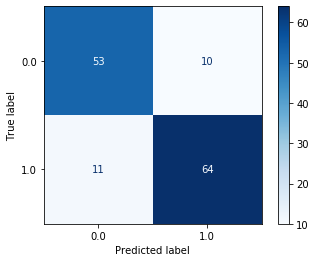

In [166]:
print('Voting Classifier')
plot_confusion_matrix(trained_models[4], X_test, y_test, cmap='Blues');

In [107]:
#Pickling Model to be use for prediction
pd.to_pickle(trained_models[4], 'pickle/model.pkl')